# Inference for GPs

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
from sklearn.gaussian_process import GaussianProcess
from sklearn.cross_validation import train_test_split


//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Recall:Definition of Gaussian Process

So lets assume we have this function vector 
$ f=(f(x_1),...f(x_n))$. If, for ANY choice of input points, $(x_1,...,x_n)$, the marginal distribution over f:

$$P(F) = \int_{f \not\in F} P(f) df$$

is multi-variate Gaussian, then the distribution $P(f)$ over the function f is said to be a Gaussian Process. 

We write a Gaussian Process thus:

$$f(x) \sim \mathcal{GP}(m(x), k(x,x\prime))$$

where the mean and covariance functions can be thought of as the infinite dimensional mean vector and covariance matrix respectively. 

By this we mean that the function $f(x)$ is drawn from a gaussian process with some probability. (It is worth repeating that a Gaussian Process defines a prior distribution over functions.) Once we have seen some data, this prior can be converted to a posterior over functions, thus restricting the set of functions that we can use based on the data. 

The consequence of the finite point marginal distribution over functions being multi-variate gaussian is that any $m$ observations in an arbitrary data set, $y = {y_1,...,y_n=m}$ can always be represented as a single point sampled from some $m$-variate Gaussian distribution. Thus, we can work backwards to 'partner' a GP with a data set, by marginalizing over the infinitely-many variables that we are not interested in, or have not observed. 

It is often assumed for simplicity that the mean of this 'partnered' GP is zero in every dimension. Then, the only thing that relates one observation to another is the covariance function  $k(x_i, x_j)$. 

There are many choices of covariance functions but a popular choice is the 'squared exponential',

$$ k(x_i, x_j) = \sigma_f^2 exp( \frac{-(x_i-x_j)^2}{2l^2}) $$

where $\sigma_f^2$ is the maximum allowable covariance (or amplitude) and $l$ is the distance in the independent variable between $x_i$ and $x_j$. Note that this is a function solely of the independent variable, rather than the dependent one i.e. the only thing that impacts the corvariance function is the distances between each set of points. 

Thus, it is the covariance function that dictates if small length scales will be more likely, and large ones will be less, for example, and thus that wiggly functions are more probable, or that more rather than less samples drawn from the GP will be wiggly.

In [3]:
x_pred = np.linspace(0, 10, 1000)

Calculate covariance based on the kernel

In [10]:
xold=np.arange(0,10,0.5)
xtrain, xtest = train_test_split(xold)
xtrain = np.sort(xtrain)
xtest = np.sort(xtest)
#trainmask=np.array([True if i in xtrain else False for i in xold])
print(xtrain, xtest)

[ 0.   0.5  1.   1.5  2.   2.5  3.5  4.   5.5  6.   6.5  7.   8.   8.5  9. ] [ 3.   4.5  5.   7.5  9.5]


At this point lets choose a regression function

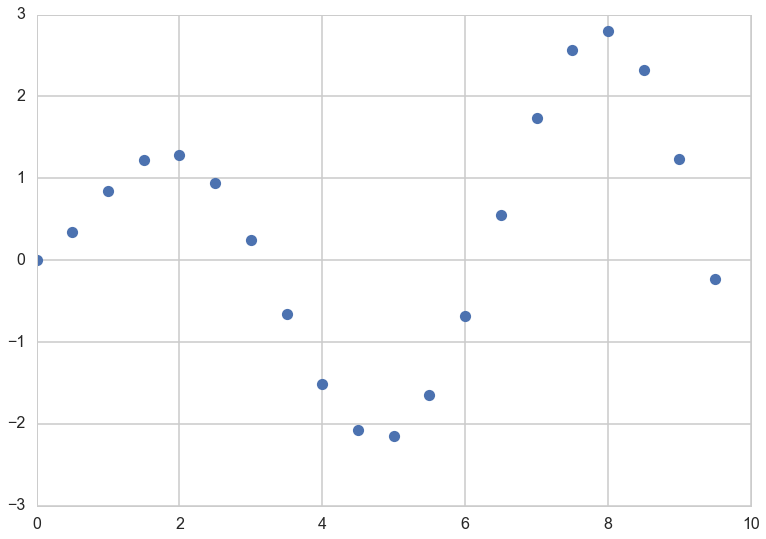

In [11]:
"""The function to predict."""
def f(x):
    return x**.5*np.sin(x)
plt.plot(xold, f(xold), 'o');

## Hyperparameter learning: Emprical Bayes or MCMC

Above we very arbitrarily chose the parameters for the GP. In a bayesian context, these are parameters of our function prior, or they are hyperpriors. In analogy with mixtures, or hierarchical models, one way of obtaing the parameters would be to write out the joint distribution and do MCMC via a MH or Gibbs sampler. This is complex, but doable by setting priors on the amplitude and length scales of the kernel and the observational noise. 

The full MCMC approach can get expensive in the limit of many training points, (indeed the matrix inversion must be done at each gibbs step). Still that is better than nothing since the training size is the dimensionality the infinite-dimensional problem has been reduced to.

We do this MCMC using the marginaly likelihood, because, after all, we want to marginalize over our "infinite set" of functions. 

$$p(y|X) = \int_f p(y|f,X)p(f|X) df$$


We could also use type-2 maximum likelihood or empirical bayes, and maximize the marginal likelihood.

 
The Marginal likelihood given a GP prior and a gaussian likelihood is:
(you can obtain this from the properties of gaussians and their integrals)

$$\log p(y|X) = - \frac{n}{2}\log2\pi - \frac{1}{2}\log|K + \sigma^2I| - \frac{1}{2}y^T(K+\sigma^2I)^{-1}y $$

where K is the covariance matrix obtained from evaluating the kernel pairwise at allpoints of the training set $X$.

The  first term is a constant, the second  is a model complexity term, and the third term
is a quadratic form of the data. To understand the tradeoff between the data and complexity term, let us consider a squared exponential kernel
in 1 dimension.

Holding the amplitude parameter fixed, lets vary the length parameter. For short length scales, the covariance is very wiggly, and thus 1 only near the diagonal. On the other hand, for large length scales, reasonably separated points are not different, and the covariance is close to 1 throughout.

Thus for shorter length scales, the model complexity term is large (the determinant is a product of diagonal terms). The fit will be very good. For longer length scales, the model complexity term will be small, as the matrix will be all ones. The fit will be poor. This corresponds to our general understanding of bias and variance: a long length scale imposes a very unwiggly, line like model, which will underfit, where as a model with a short length scale will have many wiggles, and thus possibly overfit.

To find the empirical bayes estimates of the hyperparameters, we will differentiate with respect to the hyperparameters, and set the derivatives to zero. Note that the noise variance can be added to the prior covariance hyperparameters, as is usual in the bayesian case.

Since the marginal likelihood is not convex, it can have local minima. 

Since this is a 'frequentist' optimization in a bayesian scenario, dont forget to crossvalidate or similar to get good parameter estimates.

Below we carry out the MCMC procedure using `pymc3`, and MLE for the marginal likelihood using `sklearn`.

In [32]:
# Instantiate a Gaussian Process model
sigma_noise=0.4
noise = np.random.normal(0, sigma_noise, xtrain.shape[0])
ytrain = f(xtrain) + noise

In [35]:
X = np.sort(3*np.random.rand(20))[:,None]
X

array([[ 0.34002639],
       [ 0.52470831],
       [ 0.72455156],
       [ 1.09443801],
       [ 1.11979916],
       [ 1.20905982],
       [ 1.35085969],
       [ 1.37575599],
       [ 1.59150205],
       [ 1.72575952],
       [ 1.96243359],
       [ 2.16396764],
       [ 2.20251248],
       [ 2.23850899],
       [ 2.40467709],
       [ 2.55994901],
       [ 2.76865207],
       [ 2.82255943],
       [ 2.83835445],
       [ 2.99448658]])

## Fitting a model using pymc3

(modified from http://pymc-devs.github.io/pymc3/notebooks/GP-introduction.html)

At this point, you might be wondering how to do Bayesian inference in the case of GPs. After all, to get posteriors on the hyperparameters we have to marginalize over functions, or equivalently infinite parameters.

The answer is something you might have not seen until now, but something which as always an option if the marginal likelihood integrals are analytic. Instead of optimizing the marginal likelihood, simply set up the bayesian problem as a hyperparameter posterior estimation problem. And in GPs, the marginal likelihood is simply Gaussian.

pymc3 lets us do that. See:

https://github.com/pymc-devs/pymc3/blob/master/pymc3/gp/gp.py

In [36]:
import theano.tensor as tt
with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.Uniform('l', 0, 10)

    # uninformative prior on the function variance
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))

    # uninformative prior on the noise variance
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=3)
    s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))

    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)

    y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, observed={'X':xtrain.reshape(-1,1), 'Y':ytrain})

In [37]:
with model:
    trace = pm.sample(2000)

100%|██████████| 2000/2000 [00:08<00:00, 233.92it/s]


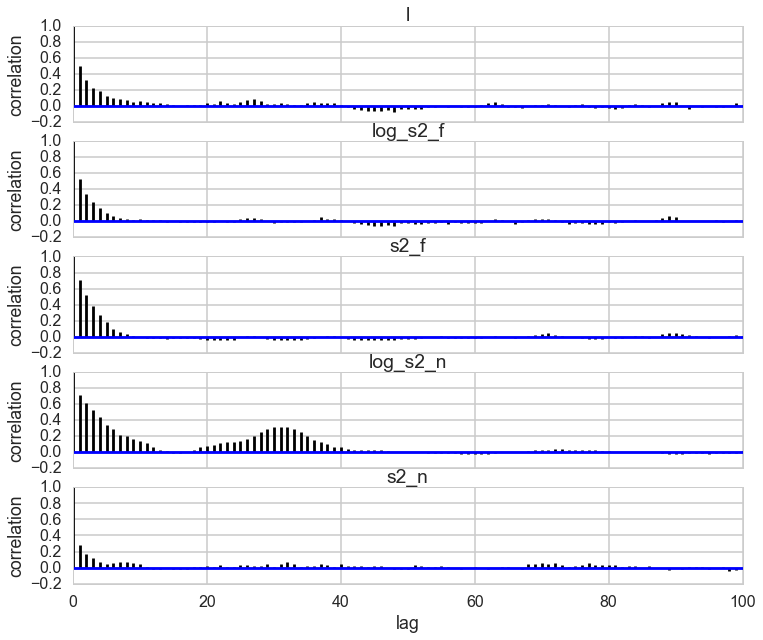

In [39]:
pm.autocorrplot(trace);

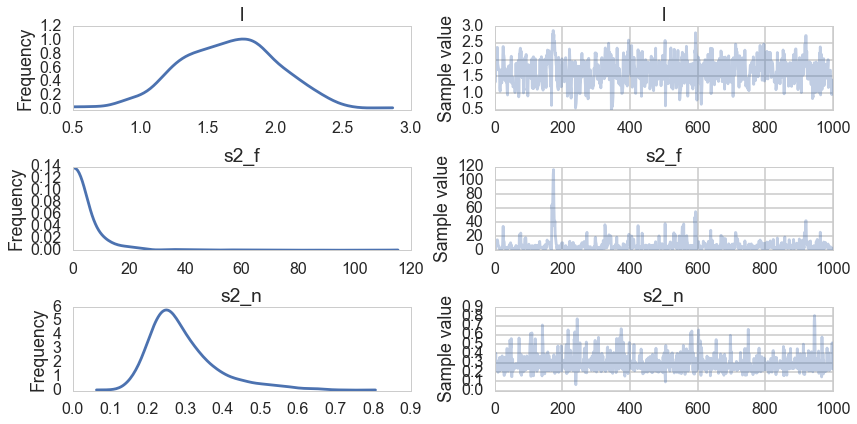

In [41]:
pm.traceplot(trace[1000:], varnames=['l', 's2_f', 's2_n']);

We can get posterior predictive samples in much the same style as `sample_ppc`, except that this being GPs, we will get back posteriot predictive functions, not just parameter traces.

In [55]:
with model:
    gp_samples = pm.gp.sample_gp(trace, y_obs, x_pred.reshape(-1,1), samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]//anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 100/100 [01:30<00:00,  1.38it/s]


In [56]:
gp_samples.shape

(100, 1000)

In [63]:
meanpred = gp_samples.mean(axis=0)
meanpred.shape

(1000,)

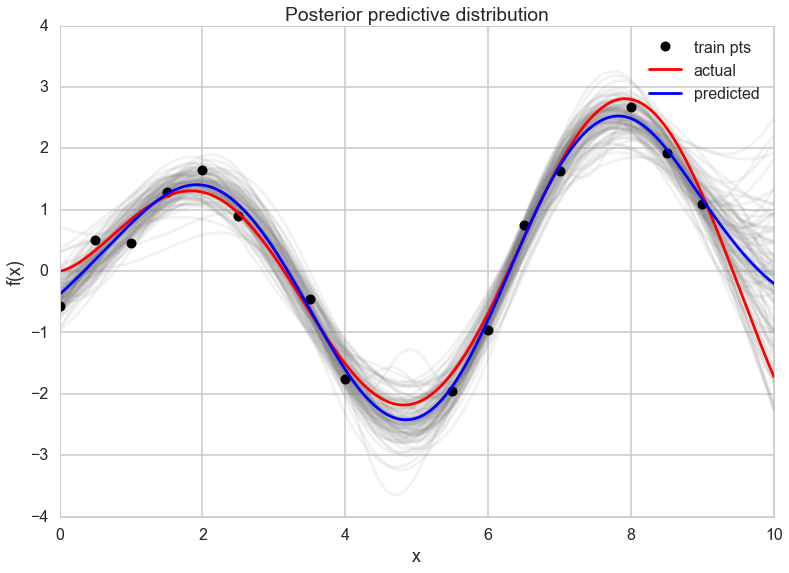

In [67]:
[plt.plot(x_pred, y, color="gray", alpha=0.1) for y in gp_samples]
# overlay the observed data
plt.plot(xtrain, ytrain, 'ok', ms=10, label="train pts");
plt.plot(x_pred, f(x_pred), 'r', ms=10, label="actual");
plt.plot(x_pred, meanpred, 'b', ms=10, label="predicted");

plt.xlabel("x");
plt.ylabel("f(x)");
plt.title("Posterior predictive distribution");
plt.xlim(0,10);
plt.legend();

## Fitting a model using `scikit-learn`

You could do marginal likeihood optimization using `scipy.optimize` yourself. `scikit-learn` also provides a slightly hard to interpret implementation, with non-zero mean. 
The `scikit-learn` [implementation](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcess.html) uses marginal-likelihood. It takes optional `regr` and `corr` arguments for the mean and covariance functions, respectively. The `regr` stands for regression, to indicate that you might want the mean function to be a regression function of some kind and use the covariance to model the residuals.

The process is 'regularized' by providing a nugget argument. This value represents the variance of the input values, such as observation error or other noise, as a **vector in units of the training values**.

In [50]:
gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-3, thetaU=10,
                     nugget=(sigma_noise/ytrain)**2,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(xtrain.reshape(-1,1), ytrain)

//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


GaussianProcess(beta0=None,
        corr=<function squared_exponential at 0x120de2840>, normalize=True,
        nugget=array([ 0.5043 ,  0.62094,  0.76346,  0.09716,  0.05853,  0.20061,
        0.76232,  0.05185,  0.04221,  0.17103,  0.28673,  0.06043,
        0.02227,  0.04343,  0.13454]),
        optimizer='fmin_cobyla', random_start=100,
        random_state=<mtrand.RandomState object at 0x11676c0d8>,
        regr=<function constant at 0x120de2620>, storage_mode='full',
        theta0=array([[ 0.1]]), thetaL=array([[ 0.001]]),
        thetaU=array([[10]]), verbose=False)

(1000,) (1000,)


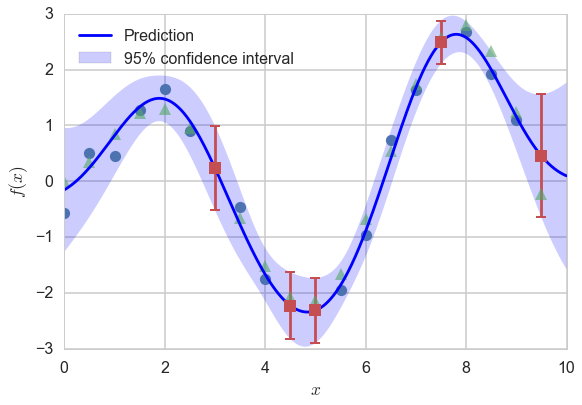

In [52]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
Xpred = x_pred.reshape(-1,1)
y_pred, MSE = gp.predict(Xpred, eval_MSE=True)
sigma = np.sqrt(MSE)
print(y_pred.shape, MSE.shape)
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(9,6))
ax=plt.gca()
plt.plot(xtrain, ytrain, 'o');
plt.plot(xold, f(xold), '^', alpha=0.6);
plt.plot(x_pred, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([Xpred, Xpred[::-1]]), \
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]), \
        alpha=.2, fc='b', ec='None', label='95% confidence interval')
mutestn, sigtestsn = gp.predict(xtest.reshape(-1,1), eval_MSE=True)
plt.errorbar(xtest, mutestn, yerr=1.96*np.sqrt(sigtestsn), capsize=5, capthick=2, marker="s", ls='None');
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')

I leave getting a more robust fit using cross-validation as an exercise.

## Sockeye Salmon example

Munch, Kottas and Mangel (Bayesian nonparametric analysis of stock- recruitment relationships. Canadian Journal of Fisheries and Aquatic Sciences, 62:1808–1821, 2005.) use Gaussian process priors to infer stock-recruitment (SR) functions for various fish. We concentrate here on Sockeye Salmon. SR functions relate the size of a fish stock to the number or biomass of recruits to the fishery each year.  The authors argue that GP priors make sense to use since model uncertainty is high in Stock Recruitment theory.

Here we see the difference between using ane xponential covariance and a Matern Covariance.

In [17]:
sockeye_data = np.reshape([2986,9,
3424,12.39,
1631,4.5,
784,2.56,
9671,32.62,
2519,8.19,
1520,4.51,
6418,15.21,
10857,35.05,
15044,36.85,
10287,25.68,
16525,52.75,
19172,19.52,
17527,40.98,
11424,26.67,
24043,52.6,
10244,21.62,
30983,56.05,
12037,29.31,
25098,45.4,
11362,18.88,
24375,19.14,
18281,33.77,
14192,20.44,
7527,21.66,
6061,18.22,
15536,42.9,
18080,46.09,
17354,38.82,
17301,42.22,
11486,21.96,
20120,45.05,
10700,13.7,
12867,27.71,], (34,2))
sockeye_data

array([[  2.98600000e+03,   9.00000000e+00],
       [  3.42400000e+03,   1.23900000e+01],
       [  1.63100000e+03,   4.50000000e+00],
       [  7.84000000e+02,   2.56000000e+00],
       [  9.67100000e+03,   3.26200000e+01],
       [  2.51900000e+03,   8.19000000e+00],
       [  1.52000000e+03,   4.51000000e+00],
       [  6.41800000e+03,   1.52100000e+01],
       [  1.08570000e+04,   3.50500000e+01],
       [  1.50440000e+04,   3.68500000e+01],
       [  1.02870000e+04,   2.56800000e+01],
       [  1.65250000e+04,   5.27500000e+01],
       [  1.91720000e+04,   1.95200000e+01],
       [  1.75270000e+04,   4.09800000e+01],
       [  1.14240000e+04,   2.66700000e+01],
       [  2.40430000e+04,   5.26000000e+01],
       [  1.02440000e+04,   2.16200000e+01],
       [  3.09830000e+04,   5.60500000e+01],
       [  1.20370000e+04,   2.93100000e+01],
       [  2.50980000e+04,   4.54000000e+01],
       [  1.13620000e+04,   1.88800000e+01],
       [  2.43750000e+04,   1.91400000e+01],
       [  

In [19]:
abundance = sockeye_data[:,0].ravel()
fry = sockeye_data[:,1].ravel()
print(abundance, fry)

[  2986.   3424.   1631.    784.   9671.   2519.   1520.   6418.  10857.
  15044.  10287.  16525.  19172.  17527.  11424.  24043.  10244.  30983.
  12037.  25098.  11362.  24375.  18281.  14192.   7527.   6061.  15536.
  18080.  17354.  17301.  11486.  20120.  10700.  12867.] [  9.    12.39   4.5    2.56  32.62   8.19   4.51  15.21  35.05  36.85
  25.68  52.75  19.52  40.98  26.67  52.6   21.62  56.05  29.31  45.4
  18.88  19.14  33.77  20.44  21.66  18.22  42.9   46.09  38.82  42.22
  21.96  45.05  13.7   27.71]


In [20]:
g3 = GaussianProcess(theta0=1.0e-3,nugget=1e-12)
g3.fit(abundance.reshape(-1,1), fry)
# thetaL=1e-5, thetaU=1,

//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


GaussianProcess(beta0=None,
        corr=<function squared_exponential at 0x120de2840>, normalize=True,
        nugget=array(1e-12), optimizer='fmin_cobyla', random_start=1,
        random_state=<mtrand.RandomState object at 0x11676c0d8>,
        regr=<function constant at 0x120de2620>, storage_mode='full',
        theta0=array([[ 0.001]]), thetaL=None, thetaU=None, verbose=False)

In [21]:
abundance_pred = np.linspace(abundance.min(), abundance.max())

In [22]:
fry_pred, fry_mse=g3.predict(abundance_pred.reshape(-1,1), eval_MSE=True)

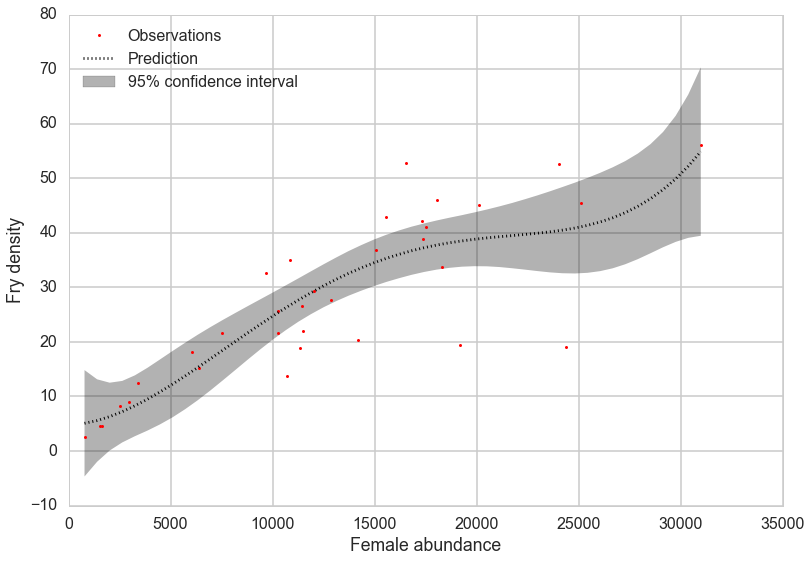

In [23]:
plt.plot(abundance, fry, 'r.', markersize=6, label=u'Observations')
plt.plot(abundance_pred, fry_pred, 'k:', label=u'Prediction')
sigma_pred=np.sqrt(fry_mse)
plt.fill(np.concatenate([abundance_pred.reshape(-1,1), abundance_pred.reshape(-1,1)[::-1]]),
        np.concatenate([fry_pred - 1.9600 * sigma_pred,
                       (fry_pred + 1.9600 * sigma_pred)[::-1]]),
        alpha=.3, fc='k', ec='None', label='95% confidence interval')
plt.xlabel('Female abundance')
plt.ylabel('Fry density')
plt.legend(loc='upper left')

In [24]:
g3.theta_

array([[ 0.001]])

In [26]:
#from https://www.mail-archive.com/scikit-learn-general@lists.sourceforge.net/msg09297.html
from scipy.special import kv # The modified bessel function of the second kind
from scipy.special import gamma # The gamma function
def matern(theta, d):
    """
    Matern correlation model.
    (Explicitly controls the degree of differentiability of the prediction.)

                                   n    / 1 / (2 ^ (nu - 1) * gamma(nu))    \
    theta, dx --> r(theta, dx) =  prod  | * abs(theta_i * d_i) ^ nu         |
                                 i = 1  \ * kv(nu, abs(theta_i * d_i))      /

    where kv is the modified bessel function of the second kind
    (from scipy.special).

    Parameters
    ----------
    theta : array_like
        An array with shape 1+1 (isotropic) or n+1 (anisotropic) giving the
        autocorrelation parameter(s) (theta, nu).

    dx : array_like
        An array with shape (n_eval, n_features) giving the componentwise
        distances between locations x and x' at which the correlation model
        should be evaluated.

    Returns
    -------
    r : array_like
        An array with shape (n_eval, ) with the values of the autocorrelation
        model.

    See also
    --------
    matern_once_differentiable, matern_twice_differentiable
    """

    theta = np.asanyarray(theta, dtype=np.float)
    d = np.asanyarray(d, dtype=np.float)

    if d.ndim > 1:
        n_features = d.shape[1]
    else:
        n_features = 1

    lth = theta.size
    if n_features > 1 and lth == 2:
        theta = np.hstack([np.repeat(theta[0], n_features), theta[1]])
    elif lth != n_features + 1:
        raise Exception("Length of theta must be 2 or %s" % (n_features + 1))
    else:
        theta = theta.reshape(1, lth)

    nu = theta[:, -1]
    td = 2. * np.sqrt(nu) \
            * theta[:, 0:-1].reshape(1, n_features) * np.abs(d)
    r = 1. / (2. ** (nu - 1.) * gamma(nu)) * td ** nu * kv(nu, td)
    r[td <= 1e-5] = 1. # The modified Bessel function of the second kind
                       # is badly defined around 0.
    r = np.prod(r, 1)

    return r


In [27]:
g4 = GaussianProcess(regr='linear', corr=matern, 
    thetaL=[0.5, 1], theta0=[1, 1.4], thetaU=[2,2] ,
    random_start = 100, nugget=1e-12)
g4.fit(abundance.reshape(-1,1), fry)

//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


GaussianProcess(beta0=None, corr=<function matern at 0x124761c80>,
        normalize=True, nugget=array(1e-12), optimizer='fmin_cobyla',
        random_start=100,
        random_state=<mtrand.RandomState object at 0x11676c0d8>,
        regr=<function linear at 0x120de26a8>, storage_mode='full',
        theta0=array([[ 1. ,  1.4]]), thetaL=array([[ 0.5,  1. ]]),
        thetaU=array([[2, 2]]), verbose=False)

In [28]:
g4.theta_

array([ 2.00004416,  0.99988701])

In [29]:
frym_pred, frym_mse=g4.predict(abundance_pred.reshape(-1,1), eval_MSE=True)

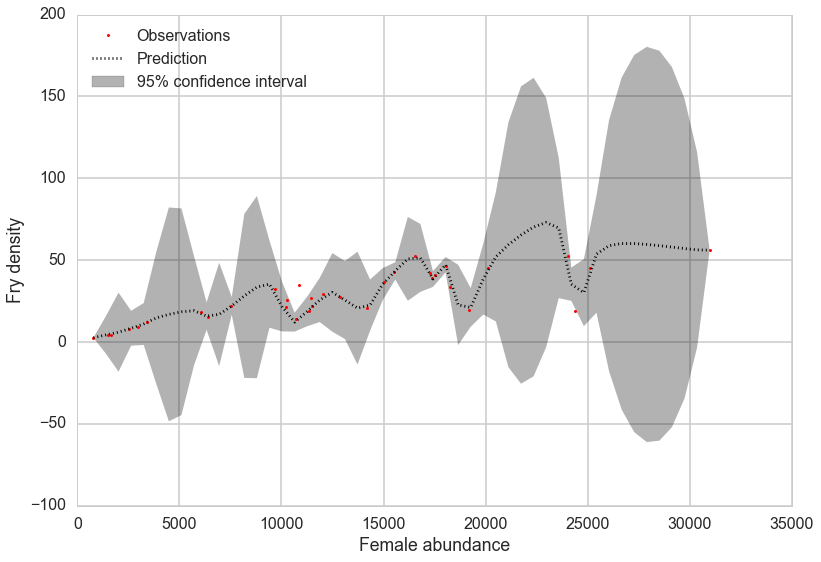

In [30]:
plt.plot(abundance, fry, 'r.', markersize=6, label=u'Observations')
plt.plot(abundance_pred, frym_pred, 'k:', label=u'Prediction')
sigmam_pred=np.sqrt(frym_mse)
plt.fill(np.concatenate([abundance_pred.reshape(-1,1), abundance_pred.reshape(-1,1)[::-1]]),
        np.concatenate([frym_pred - 1.9600 * sigmam_pred,
                       (frym_pred + 1.9600 * sigmam_pred)[::-1]]),
        alpha=.3, fc='k', ec='None', label='95% confidence interval')
plt.xlabel('Female abundance')
plt.ylabel('Fry density')
plt.legend(loc='upper left')

A pymc implementation is left as an exercise

## Where are GPs used?

- geostatistics with kriging, oil exploration
- spatial statistics
- as an interpolator (0 noise case) in weather simulations
- they are equivalent to many machine learning models such as kernelized regression, SVM and neural networks (some)
- ecology since model uncertainty is high
- they are the start of non-parametric regression
- time series analysis (see cover of BDA)
- because of the composability of kernels, in automatic statistical analysis (see the automatic statistician)